In [30]:
%matplotlib inline
from deco.imports import *
from deco.context import *
import json
from pprint import pprint
import sklearn.ensemble as st
from sklearn.model_selection import *
from datetime import datetime
import random
from math import sin, cos, sqrt, atan2, radians
import networkx as nx
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
PATH = '/home/rotem/Documents/code/optimization-course/'

In [4]:
def choose_columns(df_grid, select_cols=['pickup_datetime', 'trip_time_in_secs', 'trip_distance']):
    df_grid = df_grid.copy()
    df_reference = pd.read_csv(PATH + 'trip_data_1.csv', error_bad_lines=False, warn_bad_lines=False, nrows=1)
    df_grid.columns = list(df_reference.columns) + ['pickup_grid', 'dropoff_grid']
    df_grid = df_grid[select_cols].sort_values(select_cols[0])
    return df_grid

def format_dates(df):
    df = df.copy()
    df.pickup_datetime = pd.to_datetime(df.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
    df['time_of_day'] = df.pickup_datetime.apply(lambda d: d.timestamp() % (24 * 60 * 60))
    df['DATE'] = df.pickup_datetime.dt.strftime('%Y-%m-%d')
    return df

def load_data(pickup_grid='87G8Q279+', dropoff_grid='87G8Q225+'):
    df_grid = pd.read_csv(f'{PATH}/trip_data_{pickup_grid}_{dropoff_grid}.csv', header=None)
    df_grid = choose_columns(df_grid)
    df_grid = format_dates(df_grid)
    return df_grid

In [5]:
def add_holidays(df):
    df = df.copy()
    usa_holidays = pd.read_csv(PATH + 'usholidays.csv')
    usa_holidays.columns = [c.upper() for c in usa_holidays.columns]
    usa_holidays = usa_holidays[['DATE', 'HOLIDAY']]
    df = df.merge(usa_holidays, on=['DATE'], how='left')
    df.HOLIDAY = df.HOLIDAY.apply(lambda v: 1 if v else 0)
    return df

def add_weather(df):
    df = df.copy()
    weather = pd.read_csv(PATH + 'nyc-weather.csv')
    weather = weather[weather.NAME == 'NY CITY CENTRAL PARK, NY US'][['DATE', 'TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5', 'WSF2', 'WSF5']]
    weather.TMAX = (weather.TMAX - 32) * 5.0/9.0
    weather.TMIN = (weather.TMIN - 32) * 5.0/9.0
    df = df.merge(weather, on=['DATE'], )
    return df

def add_date_parts(df):
    df = df.copy()
    attrs = ['Dayofweek', 'Day', 'Month', ]
    for attr in attrs:
        df[f'pickup_datetime{attr.lower()}'] = getattr(df.pickup_datetime.dt, attr.lower())
    return df

def add_stock_daily_diff(df):
    df = df.copy()
    p = pd.read_csv(PATH + 'prices.csv')
    p = p[(p.date >= '2013') & (p.date < '2014') ]
    p.date = p.date.apply(lambda v: v[:10])
    p['price'] = p.close - p.open
    p['DATE'] = p.date
    p = p.groupby('DATE', as_index=False).agg({'close': 'mean', 'open': 'mean'}).sort_values('DATE')
    p = p.reset_index(drop=True).merge(p, left_index=True, right_index=True)
    p['price'] = p.close_x - p.open_y
    p['DATE'] = p.DATE_x
    p = p[['DATE', 'price']]
    display(plt.plot(p.DATE, p.price))
    df = df.merge(p, on=['DATE'], how='left')
    return df

In [6]:
features = [add_holidays, add_weather, add_date_parts]
def apply_features(base_df, features=features):
    df = base_df.copy()
    for feature in features:
        df = feature(df)
    df = df.sort_values('pickup_datetime')
    return df

In [7]:
def clean_anomalys(df):
    df.copy()
    df = df[(df.trip_distance > 0.05) & (df.trip_distance <= 2)]
    return df

In [8]:
df = load_data()
df = apply_features(df)
df = clean_anomalys(df)

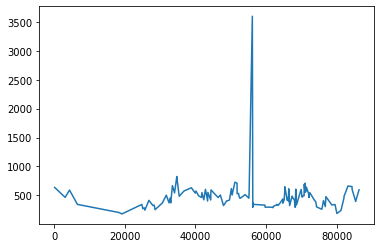

In [9]:
g = df[df.DATE == '2013-03-01'].reset_index(drop=True)
plt.plot(g.time_of_day, g.trip_time_in_secs / g.trip_distance)

In [10]:
## not in use - expiramental removal of "false" drives
# for iteration in range(10):
#     data = df.trip_distance
#     mu, std = norm.fit(data)
#     vals = plt.hist(df.trip_distance, bins=100, density=True, alpha=0.6, color='g')
#     xmin, xmax = plt.xlim()
#     x = np.linspace(xmin, xmax, 50)
#     p = norm.pdf(x, mu, std)
#     plt.plot(x, p, 'k', linewidth=2)
#     title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
#     plt.title(title)
    
#     max_diff = 0
#     max_loc = 0
#     candidate = []
#     for index, bucket in enumerate(list(zip(vals[1], vals[0]))):
#         for point in [item for item in data.drop_duplicates() if vals[1][index] <= item <= vals[1][index + 1]]:
#             d = abs(norm.pdf(point, mu, std) - bucket[1])
#             if d > max_diff:
#                 max_diff = d
#                 max_loc = index
#                 candidate = point
    
# #     max_bucket = list(vals[0]).index(max(vals[0]))
# #     cendidates = [item for item in data.drop_duplicates() if vals[1][max_bucket] <= item <= vals[1][max_bucket + 1]]
# #     max_diff = max(candidates)
#     print(candidate, max_diff, max_loc)
#     df = df[df.trip_distance != candidate]

In [11]:
df = df.drop(['pickup_datetime', 'DATE'], axis=1)

In [12]:
df.WSF5 = df.WSF5.apply(lambda x: 0 if np.isnan(x) else x)
df.WDF5 = df.WDF5.apply(lambda x: 0 if np.isnan(x) else x)
# df.price = df.price.apply(lambda x: 0 if np.isnan(x) else x)
display(df.columns)

Index(['trip_time_in_secs', 'trip_distance', 'time_of_day', 'HOLIDAY', 'TMAX',
       'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5', 'WSF2', 'WSF5',
       'pickup_datetimedayofweek', 'pickup_datetimeday',
       'pickup_datetimemonth'],
      dtype='object')

In [13]:
train_df, test_df = train_test_split(df[df.trip_distance > 0.25], test_size=0.2, random_state=42)
x_train, y_train = train_df.drop('trip_time_in_secs', axis=1), train_df.trip_time_in_secs
x_test, y_test = test_df.drop('trip_time_in_secs', axis=1), test_df.trip_time_in_secs

In [14]:
def l1_diff(x, y):
    return abs((x-y))

In [15]:
tests_results = []

In [16]:
def print_score(m):
    rows = []
    rows.append(['l1 - mean', l1_diff(m.predict(x_train), y_train).mean(), l1_diff(m.predict(x_test), y_test).mean()])
    rows.append(['l1 - std', l1_diff(m.predict(x_train), y_train).std(), l1_diff(m.predict(x_test), y_test).std()])
    rows.append(['l1 - quantile', l1_diff(m.predict(x_train), y_train).quantile(), l1_diff(m.predict(x_test), y_test).quantile()])
    rows.append(['l1 - min', l1_diff(m.predict(x_train), y_train).min(), l1_diff(m.predict(x_test), y_test).min()])
    rows.append(['l1 - max', l1_diff(m.predict(x_train), y_train).max(), l1_diff(m.predict(x_test), y_test).max()])
    rows.append(['r2', m.score(x_train, y_train), m.score(x_test, y_test)])
    df = pd.DataFrame(rows, columns=['name', 'train', 'test'])
    
    if tests_results:
        print('last test:')
        display(tests_results.pop())
    tests_results.append(df)
    print('latest test:')
    display(df)

In [17]:
m = st.RandomForestRegressor(n_jobs=-1, n_estimators=40, max_features=0.9, min_samples_leaf=3, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

latest test:


,name,train,test
0,l1 - mean,61.299260,96.530693
1,l1 - std,65.643332,95.537649
2,l1 - quantile,44.363849,73.073383
3,l1 - min,0.004414,0.045005
4,l1 - max,2960.632738,2779.795179
5,r2,0.878286,0.722556


In [32]:
m = st.ExtraTreesRegressor(n_jobs=-1, n_estimators=300, max_features=0.5, min_samples_leaf=3, )
m.fit(x_train, y_train)
print_score(m)

[90.23820928057613, 122.6844316411747, 0.7932020943111237, 0.6149679251313769]


In [19]:
from sklearn.linear_model import LinearRegression
m = LinearRegression()
m.fit(x_train, y_train)
print_score(m)

[191.34498197239742, 187.1700421361616, 0.18748817439192178, 0.17710458812129182]


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
print(f'rows: {len(rows)}')
pm = make_pipeline(PolynomialFeatures(10, order='F'), LinearRegression())
pm.fit(rows, m.predict(rows))
# print_score(pm)

rows: 67


In [36]:
def pretty_preds(preds, buffer=10):
    for i in range(len(preds)):
        preds_range = preds[max(i-buffer, 0):min(i+buffer, len(preds) - 1)]
        preds[i] = sum(preds_range) / len(preds_range)
    return preds

In [212]:
def plot_day_with_predict_func(predict):
    gen = x_test.sample(n=1, random_state=42)
    display(gen)
    gen = gen.values[0]
    cols = list(x_test.columns)
    x, y = [], []
    for i in range(0, 60 * 60 * 24, 100):
        x.append(i / 60 / 60)
        y.append(predict(gen, i))
    plt.plot(x, y)

,trip_distance,time_of_day,HOLIDAY,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5,pickup_datetimedayofweek,pickup_datetimeday,pickup_datetimemonth
8405,0.96,36960.0,1,10.555556,2.777778,0.0,0.0,0.0,5.82,310.0,350.0,13.0,23.0,3,28,3


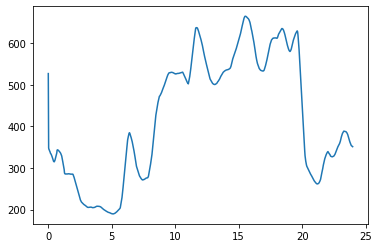

In [214]:
plot_day_with_predict_func(predict)

In [150]:
import hashlib
CACHE = {}

In [162]:
def predict(row, time_of_day=None, buffer=1000, buffer_samples=21):
    cols = list(x_test.columns)
    rows = []
    time_of_day = time_of_day or row[cols.index('time_of_day')]
    row_hash = [str(item) for index, item in enumerate(row) if index != cols.index('time_of_day')]
    row_hash = hashlib.md5('_'.join(row_hash).encode()).digest()
    if row_hash not in CACHE:
        CACHE[row_hash] = {}
    preds = []
    for i in np.linspace(max(time_of_day - buffer, 0), min(time_of_day + buffer, 60 * 60 * 24), buffer_samples):
        if i in CACHE[row_hash]:
            preds.append(CACHE[row_hash][i])
        else:
            row = row.copy()
            row[cols.index('time_of_day')] = i
            rows.append(row)
    if rows:
        rows = pd.DataFrame(rows, columns=cols)
        preds_new = m.predict(rows)
        preds.extend(preds_new)
        for i, p in zip(rows.time_of_day, preds_new):
            CACHE[row_hash][i] = p
    return sum(preds) / len(preds)

In [196]:
def predict(row, time_of_day=None, buffer=1000, buffer_samples=21):
    time_of_day_index = list(x_test.columns).index('time_of_day')
    rows = []
    time_of_day = time_of_day or row[time_of_day_index]
    for i in np.linspace(max(time_of_day - buffer, 0), min(time_of_day + buffer, 60 * 60 * 24), buffer_samples):
        row = row.copy()
        row[time_of_day_index] = i
        rows.append(row)
    rows = pd.DataFrame(rows, columns=cols)
    preds = m.predict(rows)
    return preds.mean()

In [197]:
## time - time_of_day_max <= 0
## time_of_day_min - time <= 0
def penalty_predict(row, time_of_day, time_of_day_min, time_of_day_max, factor=1):
    res = predict(row, time_of_day)
    res += factor * max([time_of_day - time_of_day_max, 0]) ** 2
    res += factor * max([time_of_day_min - time_of_day, 0]) ** 2
    return res

In [275]:
import random

In [322]:
def minimize_penalty_in_boundry(row, x0, xmin, xmax, factor_iterations, error=1e-5):
    print(f'minimize using {x0}, {xmin}, {xmax}, {factor_iterations}')
    res = None
    last_res = None
    counter = 0
    while (res is None or last_res is None or last_res[0] - res[0] > error) and counter < factor_iterations:
        last_res = res
        res_ = scipy.optimize.fmin(lambda x: penalty_predict(row, x, xmin, xmax, 10 ** counter), res[1] if res else x0)
        res_value = penalty_predict(row, res_, xmin, xmax, 10 ** counter)
        res = [res_value, res_[0],]
        counter += 1
    return res

def minimize_penalty(row, x0, xmin, xmax, factor_iterations=5, boundry_iterations=10, error=1e-3):
    counter = 0
    min_res = minimize_penalty_in_boundry(row, x0, xmin, xmax, factor_iterations, error)
    min_left = None
    min_right = None
    while (min_left is None or min_right is None \
        or max([min_res[0] - min_left[0], min_res[0] - min_right[0]]) > error) \
        and counter < boundry_iterations:
        min_res = min([min_res, min_left or [float('infinity')], min_right or [float('infinity')]])
        print(f'current minimum is {min_res[0], min_res[1] / 60 / 60}')
        min_left = minimize_penalty_in_boundry(row, xmin / 2, xmin, min_res[1], factor_iterations, error)
        min_right = minimize_penalty_in_boundry(row, xmax * 2, min_res[1], xmax, factor_iterations, error)
        counter += 1
    return min_res

In [325]:
gen = x_test.sample(n=1, random_state=42)
display(gen)
gen = gen.values[0]

res = minimize_penalty(gen, 6, 15 * 60 * 60, 24 * 60 * 60, )

,trip_distance,time_of_day,HOLIDAY,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5,pickup_datetimedayofweek,pickup_datetimeday,pickup_datetimemonth
8405,0.96,36960.0,1,10.555556,2.777778,0.0,0.0,0.0,5.82,310.0,350.0,13.0,23.0,3,28,3


minimize using 6, 54000, 86400, 5
Optimization terminated successfully.
         Current function value: 261.490445
         Iterations: 47
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 261.490445
         Iterations: 27
         Function evaluations: 74
current minimum is (261.49044475365906, 21.18558333333343)
minimize using 27000.0, 54000, 76268.10000000034, 5
Optimization terminated successfully.
         Current function value: 261.569185
         Iterations: 39
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: 261.490445
         Iterations: 28
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 261.490445
         Iterations: 27
         Function evaluations: 70
minimize using 172800, 76268.10000000034, 86400, 5
Optimization terminated successfully.
         Current function value: 261.501517
         Iterations: 

In [327]:
res[1] / 60 / 60

21.18558333333343

In [302]:
float('infinity')

inf